In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Main path configuration**

In [4]:
main_path ='/content/drive/MyDrive/Animals'
foldernames = os.listdir(main_path)

**Accesing each folder and print it**

In [5]:
foldernames = os.listdir(main_path)
print(foldernames)


['Jaguar', 'Leopard', 'Cheetah', 'Tiger', 'Lion']


**Data preprocessing**

In [ ]:
for folder in foldernames:
    individualpath = os.path.join(main_path, folder)
    imgnames = os.listdir(individualpath)

    for img in imgnames:
        each_img_path = os.path.join(individualpath, img)
        read_img = cv2.imread(each_img_path)

        if read_img is not None:
            rgb_img = cv2.cvtColor(read_img, cv2.COLOR_BGR2RGB)
            resize_img = cv2.resize(rgb_img, (300, 300))
            plt.imshow(resize_img)
            plt.show()

In [7]:
for folder in foldernames:
    individualpath = os.path.join(main_path, folder)
    imgnames = os.listdir(individualpath)
    label=foldernames.index(folder)
    print(folder,label)


Jaguar 0
Leopard 1
Cheetah 2
Tiger 3
Lion 4


**Convert RGB images into Gray images and store it as a training dataset**

In [ ]:
X_train=[]
for folder in foldernames:
    individualpath = os.path.join(main_path, folder)
    imgnames = os.listdir(individualpath)
    label=foldernames.index(folder)
    for img in imgnames:
        each_img_path = os.path.join(individualpath, img)
        read_img = cv2.imread(each_img_path)
        if read_img is not None:
            rgb_img = cv2.cvtColor(read_img, cv2.COLOR_BGR2RGB)
            resize_img = cv2.resize(rgb_img, (300, 300))
            gray_img=cv2.cvtColor(resize_img,cv2.COLOR_RGB2GRAY)
            X_train.append([gray_img,label])
            plt.imshow(gray_img,cmap='gray')
            plt.xlabel(folder)
            plt.show()

**Shuffle the dataset**

In [ ]:
import random
random.shuffle(X_train)
plt.figure(figsize=(20,30))
for i in range(48):
  plt.subplot(8,6,i+1)
  plt.imshow(X_train[i][0],cmap='gray')
  plt.xlabel(foldernames[X_train[i][1]])
plt.show()


In [10]:
print(len(X_train))

170


**For KNN,use L2 distance and 5 fold cross validation.Divide the dataset into 5 fold where four fold will use as training dataset and one fold as the validation set**

In [27]:
def comparator(dis):
  return dis[2]




In [28]:
def euclidian_distance(training_img,validate_img):
  return np.sqrt(np.sum((training_img-validate_img)**2))

**This will help to find out the distance between validation image with other training image for each fold**

In [29]:
def distance(training_data,validate_data):
  list_dis=[]
  for validate_img in validate_data:
    val_label_train_label_distance=[]
    for training_img in training_data:
      l2_distance=euclidian_distance(training_img[0],validate_img[0])
      val_label_train_label_distance.append([training_img[1],validate_img[1],l2_distance])

    val_label_train_label_distance.sort(key=comparator)
    first_thirty_data=val_label_train_label_distance[:]
    list_dis.append(val_label_train_label_distance)
  return list_dis



**Split the dataset into five fold**

In [30]:
fold1 = X_train[:34]
fold2 = X_train[34:68]
fold3 = X_train[68:102]
fold4 = X_train[102:136]
fold5 = X_train[136:]

**Use five fold cross validation**

In [31]:
first_train = fold1 + fold2 + fold3 + fold4
first_validate=fold5
second_train=fold1+fold2+fold3+fold5
second_validate=fold4
third_train=fold1+fold2+fold4+fold5
third_validate=fold3
fourth_train=fold1+fold3+fold4+fold5
fourth_validate=fold2
fifth_train=fold2+fold3+fold4+fold5
fifth_validate=fold1

**Find the distance for each fold**

In [32]:
list_dis_one=distance(first_train,first_validate)
print(type(list_dis_one))


<class 'list'>


In [33]:

print(len(list_dis_one))

34


In [34]:
print(len(list_dis_one[0]))


136


In [35]:
all_dis=[]


**For each fold, find the euclidian distance**

In [36]:
list_dis_two=distance(second_train,second_validate)
list_dis_three=distance(third_train,third_validate)
list_dis_four=distance(fourth_train,fourth_validate)
list_dis_five=distance(fifth_train,fifth_validate)
all_dis.append(list_dis_one)
all_dis.append(list_dis_two)
all_dis.append(list_dis_three)
all_dis.append(list_dis_four)
all_dis.append(list_dis_five)


In [37]:

print(len(all_dis))

5


**For calculate Accuracy**

In [38]:
def calculate_accuracy(list_dis_one, k_values):
    total_validation_images = len(list_dis_one)
    accuracies = []

    for k in k_values:
        correct_predictions = 0

        for validation_neighbors in list_dis_one:
            top_k_neighbors = validation_neighbors[:k]
            validation_label = top_k_neighbors[0][1]

            training_labels = [neighbor[0] for neighbor in top_k_neighbors]

            majority_label = max(set(training_labels), key=training_labels.count)

            if majority_label == validation_label:
                correct_predictions += 1

        accuracy = correct_predictions / total_validation_images
        accuracies.append(accuracy)

    return accuracies





**Use a list for K. Try to find the accuracies for each fold where k is 1 to 30**

In [39]:
k_values = list(range(1, 31, 1))
all_accuracies = []

for fold_dis in all_dis:
    fold_accuracy = calculate_accuracy(fold_dis, k_values)
    all_accuracies.append(fold_accuracy)


In [41]:
print(len(all_accuracies))

5


**Plot all the Accuracy for each specific K**

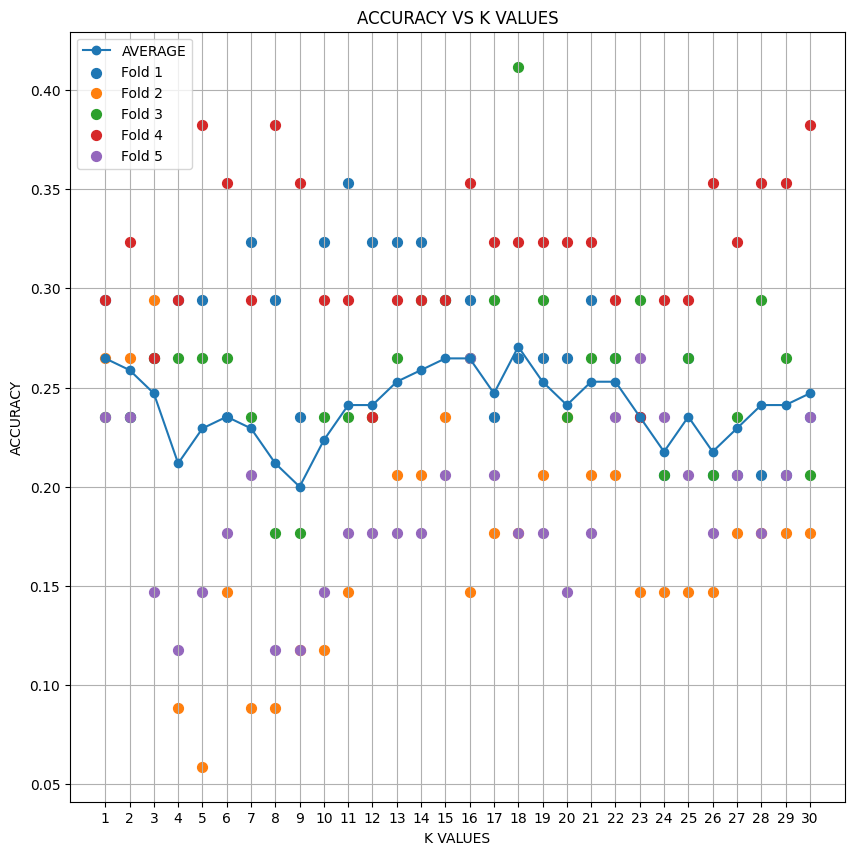

In [42]:
import matplotlib.pyplot as plt

k_values = list(range(1, 31, 1))

mean_accuracies = [sum(accuracies) / len(all_accuracies) for accuracies in zip(*all_accuracies)]

plt.figure(figsize=(10, 10))
plt.plot(k_values, mean_accuracies, marker='o', label='AVERAGE')
for i, fold_accuracies in enumerate(all_accuracies):
    plt.scatter(k_values, fold_accuracies, label=f'Fold {i+1}', marker='o', s=50)

plt.xlabel('K VALUES')
plt.ylabel('ACCURACY')
plt.title('ACCURACY VS K VALUES')
plt.xticks(k_values)
plt.legend()
plt.grid(True)
plt.show()